The goals of this notebook are to 
- validate the Microsim Kaiser population baseline characteristics against the actual Kaiser population
- validate the SBI and WMH models 
- examine the control-treated similarities/differences in WMH outcomes

In [1]:
#numpy and pandas modules are not always necessary but more often than not...
import numpy as np
import pandas as pd
#the os module is typically necessary as we always must switch to the Microsim code directory
import os
import matplotlib.pyplot as plt

#import microsim modules that we need in order to run a trial
from microsim.trials.trial_type import TrialType
from microsim.trials.trial_description import KaiserTrialDescription, NhanesTrialDescription
from microsim.risk_factor import StaticRiskFactorsType, DynamicRiskFactorsType
from microsim.person_filter_factory import PersonFilterFactory
from microsim.trials.trial_outcome_assessor_factory import TrialOutcomeAssessorFactory
from microsim.trials.trial import Trial
from microsim.outcome import OutcomeType
from microsim.wmh_severity import WMHSeverity

#switch to the Microsim directory
microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)

In [2]:
pd.set_option('future.no_silent_downcasting', True) 

In [3]:
pf=None

In [4]:
sampleSize = 300000
td = KaiserTrialDescription(trialType = TrialType.COMPLETELY_RANDOMIZED,
                            blockFactors=list(),
                            sampleSize = sampleSize, 
                            duration = 1, 
                            treatmentStrategies = "1bpMedsAdded",
                            nWorkers = 5, 
                            personFilters=pf)
td

Trial Description
	Trial type: 1
	Block factors: []
	Sample size: 300000
	Duration: 1
	Treatment strategies: ['bp', 'statin']
	Number of workers: 5
	Person filters: 
	 None
	Population type: PopulationType.KAISER

In [5]:
tr = Trial(td)
tr

Trial Description
	Trial type: 1
	Block factors: []
	Sample size: 300000
	Duration: 1
	Treatment strategies: ['bp', 'statin']
	Number of workers: 5
	Person filters: 
	 None
	Population type: PopulationType.KAISER
Trial
	Trial completed: False

In [6]:
tr.print_covariate_distributions()

                          Printing covariate information for people still alive...
                          self=treated, alive people count=  300000               other=control, alive people count=  300000  
                          self=treated, unique alive people count=  193482        other=control, unique alive people count=  193643  
                          self                                                    other
                          -----------------------------------------------------   -----------------------------------------------------
                          min      0.25    med     0.75     max    mean     sd     min     0.25    med     0.75     max    mean     sd
                          -----------------------------------------------------   -----------------------------------------------------
                    age    45.0    59.0    65.0    72.0   110.0    65.8     9.5    45.0    59.0    65.0    72.0   110.0    65.9     9.5
                    sbp  

In [7]:
%%time
tr.run()
tr

/Users/deligkaris.1/Library/Caches/pypoetry/virtualenvs/microsim-54NoInYP-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Trial is completed.
CPU times: user 3min 14s, sys: 2min 15s, total: 5min 30s
Wall time: 6min 45s


Trial Description
	Trial type: 1
	Block factors: []
	Sample size: 300000
	Duration: 1
	Treatment strategies: ['bp', 'statin']
	Number of workers: 5
	Person filters: 
	 None
	Population type: PopulationType.KAISER
Trial
	Trial completed: True

In [8]:
toa = TrialOutcomeAssessorFactory.get_trial_outcome_assessor()
toa

Trial Outcome Assessor
	Assessments:
		Name: death                    Analysis: logistic       
		Name: anyEvent                 Analysis: logistic       
		Name: vascularEventOrDeath     Analysis: logistic       
		Name: vascularEvent            Analysis: logistic       
		Name: qalys                    Analysis: linear         
		Name: meanGCP                  Analysis: linear         
		Name: lastGCP                  Analysis: linear         
		Name: cogEvent                 Analysis: logistic       
		Name: deathCox                 Analysis: cox            
		Name: cogEventCox              Analysis: cox            
		Name: vascularEventOrDeathCox  Analysis: cox            
		Name: strokeRR                 Analysis: relativeRisk   
		Name: miRR                     Analysis: relativeRisk   
		Name: cvRR                     Analysis: relativeRisk   
		Name: dementiaRR               Analysis: relativeRisk   
		Name: ciRR                     Analysis: relativeRisk   
		Name: dementiaOrC

In [9]:
tr.analyze(toa)
tr

Trial Description
	Trial type: 1
	Block factors: []
	Sample size: 300000
	Duration: 1
	Treatment strategies: ['bp', 'statin']
	Number of workers: 5
	Person filters: 
	 None
	Population type: PopulationType.KAISER
Trial
	Trial completed: True
Trial results:
	Analysis: linear
	                                         Z      Intercept           Z SE         pValue
	                    qalys:            0.00           0.95           0.00           0.00
	                  meanGCP:            0.17          53.61           0.02           0.00
	                  lastGCP:            0.17          53.61           0.02           0.00
	Analysis: logistic
	                                         Z      Intercept           Z SE         pValue
	                    death:           -0.04          -3.67           0.02           0.01
	                 anyEvent:           -0.06          -2.94           0.01           0.00
	     vascularEventOrDeath:           -0.07          -3.07           0.01         

### MicrosimKaiser-Kaiser population comparison

In [10]:
def get_info(person):
    if len(person._outcomes[OutcomeType.WMH])>0:
        age = person._outcomes[OutcomeType.WMH][0][0]
        wave = person.get_wave_for_age(age)
        gcp = person._outcomes[OutcomeType.COGNITION][wave][1].gcp
        severity = person._outcomes[OutcomeType.WMH][0][1].wmhSeverity
        sbi = person._outcomes[OutcomeType.WMH][0][1].sbi
        wmh = person._outcomes[OutcomeType.WMH][0][1].wmh
        modality = person._modality
        unknown = person._outcomes[OutcomeType.WMH][0][1].wmhSeverityUnknown
        return (gcp, severity, modality, wmh, sbi, unknown)
controlInfo = list(map(lambda x: get_info(x), tr.controlPop._people))
treatedInfo= list(map(lambda x: get_info(x), tr.treatedPop._people))

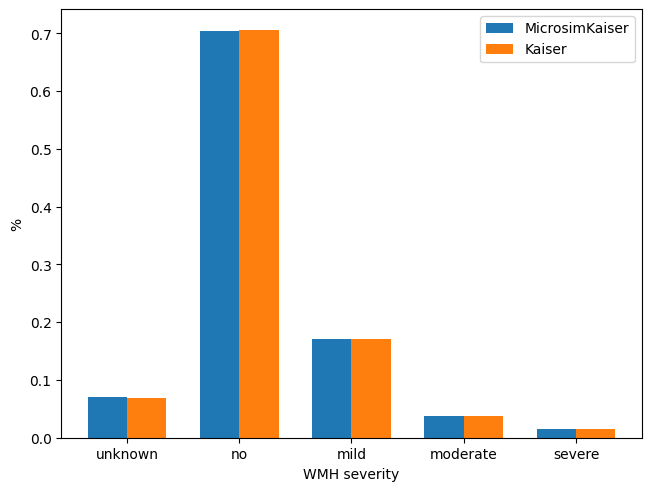

In [11]:
controlSeverity = [y.value if y is not None else "unknown" for y in [x[1] for x in controlInfo] ]
treatedSeverity = [y.value if y is not None else "unknown" for y in [x[1] for x in treatedInfo]]
bins = list(pd.Series(controlSeverity).value_counts(dropna=False).index)
binCounts = list(pd.Series(controlSeverity).value_counts(dropna=False))
xLabels = ['unknown', 'no', 'mild', 'moderate', 'severe']
xOrder = [1,2,0,3,4]
kaiserRates = [0.069, 0.7065, 0.1715, 0.0378, 0.0152]
barWidth=0.35
fig, ax = plt.subplots(layout='constrained')
ax.bar(xOrder, [x/sampleSize for x in binCounts], barWidth, tick_label=bins, label="MicrosimKaiser")
ax.bar([x+barWidth for x in range(5)], kaiserRates, barWidth, tick_label=['unknown', 'no', 'mild', 'moderate', 'severe'], label="Kaiser")
ax.legend(prop={'size': 10})
plt.xticks([x+barWidth/2 for x in range(5)], xLabels)
plt.xlabel("WMH severity")
plt.ylabel("%")
plt.show()

In [12]:
for i,counts in enumerate(binCounts):
    print(f"WMH rates {bins[i]:<10} Kaiser  {kaiserRates[xOrder[i]]:<16.4f} MicrosimKaiser {binCounts[i]/sampleSize:<16.4f}")

WMH rates no         Kaiser  0.7065           MicrosimKaiser 0.7038          
WMH rates mild       Kaiser  0.1715           MicrosimKaiser 0.1715          
WMH rates unknown    Kaiser  0.0690           MicrosimKaiser 0.0713          
WMH rates moderate   Kaiser  0.0378           MicrosimKaiser 0.0380          
WMH rates severe     Kaiser  0.0152           MicrosimKaiser 0.0154          


In [13]:
controlSbi = list(map(lambda x: x[4], controlInfo))
treatedSbi = list(map(lambda x: x[4], treatedInfo))
#list(map(lambda x: np.mean(x), [controlSbi, treatedSbi]))
print(f"Kaiser SBI rate: 0.0438, MicrosimKaiser SBI rate: {np.mean(controlSbi):<5.4f}")

Kaiser SBI rate: 0.0438, MicrosimKaiser SBI rate: 0.0430


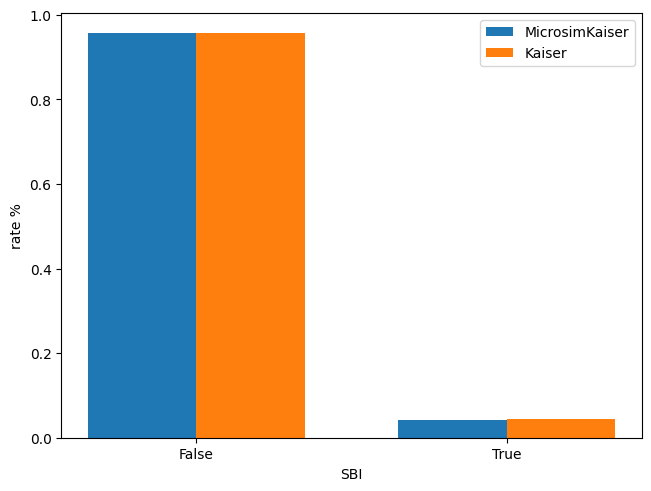

In [14]:
binsControl = list(pd.Series(controlSbi).value_counts(dropna=False).index)
binCountsControl = list(pd.Series(controlSbi).value_counts(dropna=False))
binsTreated = list(pd.Series(treatedSbi).value_counts(dropna=False).index)
binCountsTreated = list(pd.Series(treatedSbi).value_counts(dropna=False))
fig, ax = plt.subplots(layout='constrained')
ax.bar([0,1], [x/sampleSize for x in binCountsControl], barWidth, label="MicrosimKaiser")
ax.bar([x+barWidth for x in [0,1]], [0.9562, 0.0438], barWidth, label="Kaiser")
ax.legend(prop={'size': 10})
plt.xticks([x+barWidth/2 for x in range(2)], binsControl)
plt.xlabel("SBI")
plt.ylabel("rate %")
plt.show()

## Microsim control-treated comparison

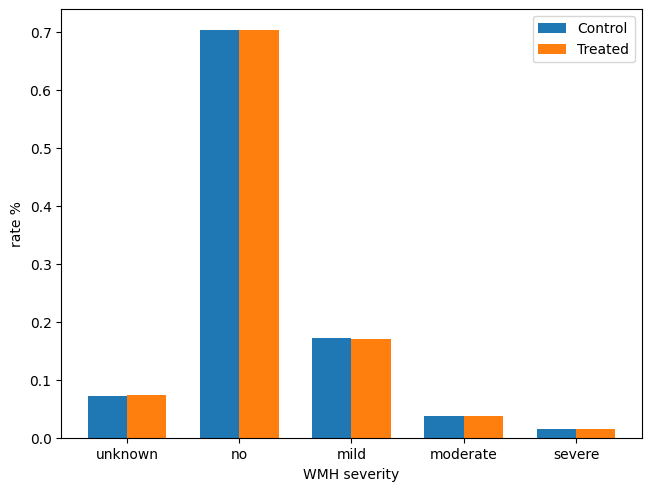

In [15]:
controlSeverity = [y.value if y is not None else "unknown" for y in [x[1] for x in controlInfo] ]
treatedSeverity = [y.value if y is not None else "unknown" for y in [x[1] for x in treatedInfo]]
binsControl = list(pd.Series(controlSeverity).value_counts(dropna=False).index)
binCountsControl = list(pd.Series(controlSeverity).value_counts(dropna=False))
binsTreated = list(pd.Series(treatedSeverity).value_counts(dropna=False).index)
binCountsTreated = list(pd.Series(treatedSeverity).value_counts(dropna=False))
barWidth=0.35
fig, ax = plt.subplots(layout='constrained')
ax.bar([1,2,0,3,4], [x/sampleSize for x in binCountsControl], barWidth, label="Control")
ax.bar([x+barWidth for x in [1,2,0,3,4]], [x/sampleSize for x in binCountsTreated], barWidth, label="Treated")
ax.legend(prop={'size': 10})
plt.xticks([x+barWidth/2 for x in range(5)], ['unknown', 'no', 'mild', 'moderate', 'severe'])
plt.xlabel("WMH severity")
plt.ylabel("rate %")
plt.show()

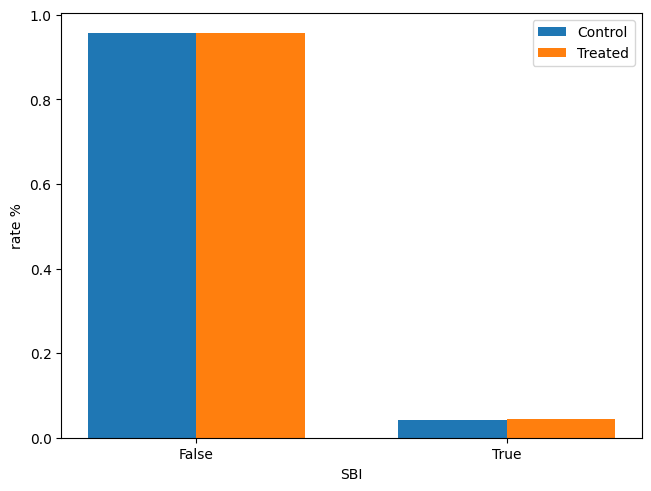

In [16]:
binsControl = list(pd.Series(controlSbi).value_counts(dropna=False).index)
binCountsControl = list(pd.Series(controlSbi).value_counts(dropna=False))
binsTreated = list(pd.Series(treatedSbi).value_counts(dropna=False).index)
binCountsTreated = list(pd.Series(treatedSbi).value_counts(dropna=False))
fig, ax = plt.subplots(layout='constrained')
ax.bar([0,1], [x/sampleSize for x in binCountsControl], barWidth, label="Control")
ax.bar([x+barWidth for x in [0,1]], [x/sampleSize for x in binCountsTreated], barWidth, label="Treated")
ax.legend(prop={'size': 10})
plt.xticks([x+barWidth/2 for x in range(2)], binsControl)
plt.xlabel("SBI")
plt.ylabel("rate %")
plt.show()

In [17]:
#WMH event rates
controlWmh = list(map(lambda x: x[3], controlInfo))
treatedWmh = list(map(lambda x: x[3], treatedInfo))
list(map(lambda x: np.mean(x), [controlWmh, treatedWmh]))

[0.2962266666666667, 0.2963766666666667]

In [18]:
#unknown severity 
controlSeverityUnknown = list(filter(lambda x: x[1] is None, controlInfo))
treatedSeverityUnknown = list(filter(lambda x: x[1] is None, treatedInfo))
(len(controlSeverityUnknown)/len(controlInfo), len(treatedSeverityUnknown)/len(treatedInfo))

(0.07131333333333334, 0.07336)

In [19]:
#same as above
controlSeverityUnknown = list(filter(lambda x: x[5]==True, controlInfo))
treatedSeverityUnknown = list(filter(lambda x: x[5]==True, treatedInfo))
(len(controlSeverityUnknown)/len(controlInfo), len(treatedSeverityUnknown)/len(treatedInfo))

(0.07131333333333334, 0.07336)

In [20]:
#severity counts for control
pd.Series(controlSeverity).value_counts()/len(controlInfo)

no          0.703773
mild        0.171530
unknown     0.071313
moderate    0.037967
severe      0.015417
Name: count, dtype: float64

In [21]:
#severity counts for treated
pd.Series(treatedSeverity).value_counts()/len(treatedInfo)

no          0.703623
mild        0.170133
unknown     0.073360
moderate    0.037480
severe      0.015403
Name: count, dtype: float64

In [22]:
gcpDataControl = dict()
gcpDataTreated = dict()
modDataControl = dict()
modDataTreated = dict()
for severity in WMHSeverity:
    gcpDataControl[severity.value] = list(map(lambda y: y[0], list(filter(lambda x: x[1]==severity, controlInfo))))
    gcpDataTreated[severity.value] = list(map(lambda y: y[0], list(filter(lambda x: x[1]==severity, treatedInfo))))
    modDataControl[severity.value] = list(map(lambda y: y[2], list(filter(lambda x: x[1]==severity, controlInfo))))
    modDataTreated[severity.value] = list(map(lambda y: y[2], list(filter(lambda x: x[1]==severity, treatedInfo))))

In [23]:
severityList = [x.value for x in WMHSeverity]
gcpControl = [gcpDataControl[x] for x in severityList]
gcpTreated = [gcpDataTreated[x] for x in severityList]
modControl = [modDataControl[x] for x in severityList]
modTreated = [modDataTreated[x] for x in severityList]

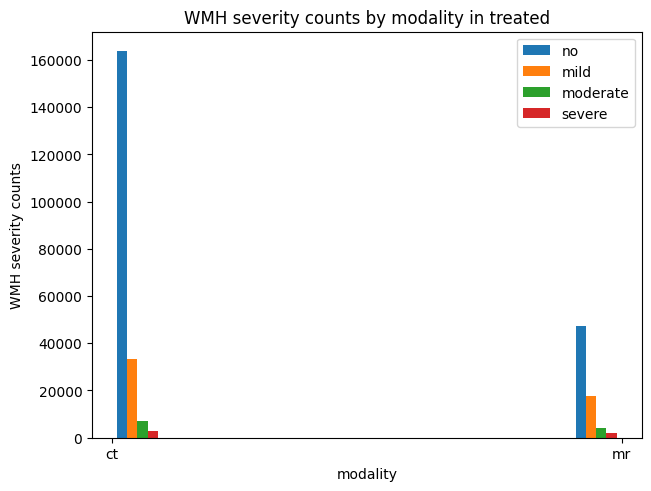

In [24]:
fig, ax = plt.subplots(layout='constrained')
ax.hist(modTreated, label=severityList)
ax.legend(prop={'size': 10})
plt.ylabel("WMH severity counts")
plt.xlabel("modality")
plt.title("WMH severity counts by modality in treated")
plt.show()

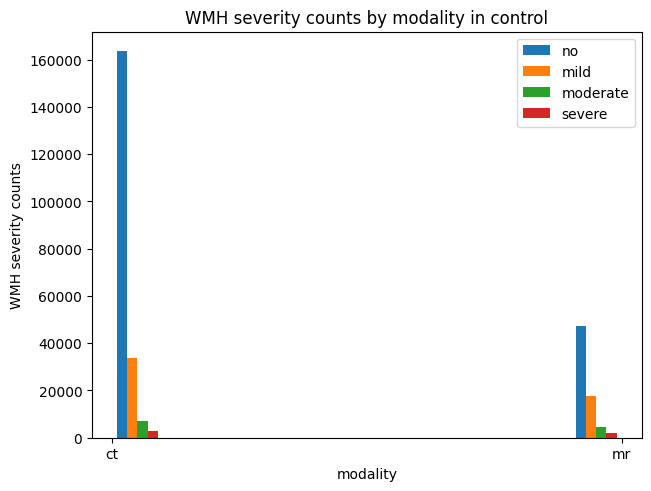

In [25]:
fig, ax = plt.subplots(layout='constrained')
ax.hist(modControl, label=severityList)
ax.legend(prop={'size': 10})
plt.ylabel("WMH severity counts")
plt.xlabel("modality")
plt.title("WMH severity counts by modality in control")
plt.show()

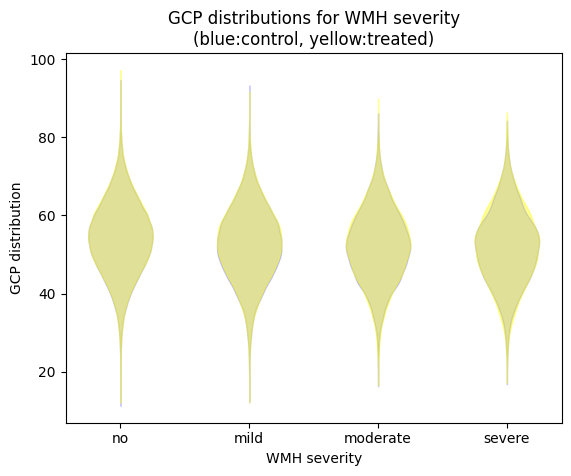

In [26]:
fig, ax = plt.subplots()
violin = ax.violinplot(gcpControl, showmeans=False, showmedians=False, showextrema=False)
#for pc in violin["bodies"]+[violin["cmins"],violin["cmaxes"]]:
for pc in violin["bodies"]:
    pc.set_facecolor("blue")
    pc.set_edgecolor("blue")
    pc.set_alpha(0.2)
violin = ax.violinplot(gcpTreated, showmeans=False, showmedians=False, showextrema=False)
#for pc in violin["bodies"]+[violin["cmins"],violin["cmaxes"]]:
for pc in violin["bodies"]:
    pc.set_facecolor("yellow")
    pc.set_edgecolor("yellow")
    pc.set_alpha(0.4)
#for pc in [violin["cmins"]]:
#    pc.set_color("black")
plt.title("GCP distributions for WMH severity\n(blue:control, yellow:treated)")
plt.xticks(list(range(1, len(severityList)+1)), severityList)  # Set category labels on x-axis
plt.xlabel('WMH severity')
plt.ylabel('GCP distribution')
plt.show()

In [27]:
for i in range(len(severityList)):
    print(f"{severityList[i]:>20}", " control gcp mean=", f"{np.mean(gcpControl[i]):>4.2f}", " treated gcp mean=", f"{np.mean(gcpTreated[i]):>4.2f}")

                  no  control gcp mean= 54.15  treated gcp mean= 54.33
                mild  control gcp mean= 52.61  treated gcp mean= 52.81
            moderate  control gcp mean= 52.20  treated gcp mean= 52.10
              severe  control gcp mean= 51.92  treated gcp mean= 51.97


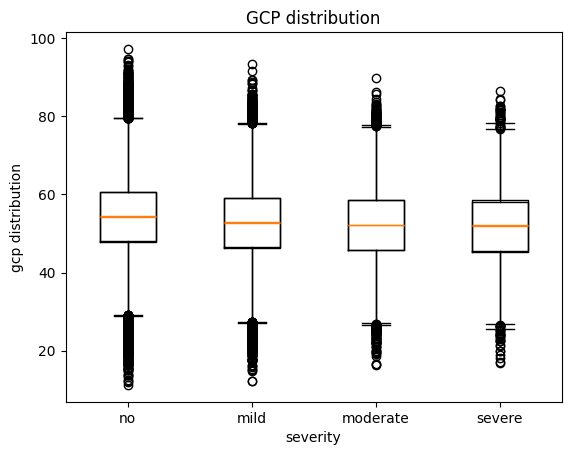

In [28]:
plt.boxplot(gcpControl)
c="red"
plt.boxplot(gcpTreated, 
            #patch_artist=True,
            #boxprops=dict(edgecolor=c, facecolor='none'),
            #capprops=dict(color=c),
            #whiskerprops=dict(color=c),
            #flierprops=dict(color=c, markeredgecolor=c),
            #medianprops=dict(color=c)
           )
plt.title("GCP distribution")
plt.xticks(list(range(1, len(severityList)+1)), severityList)  # Set category labels on x-axis
plt.xlabel('severity')
plt.ylabel('gcp distribution')
plt.show()

In [29]:
df = tr.controlPop.get_all_person_years_as_df()
df["afib"] = df["afib"].astype('int')
df["pvd"] = df["pvd"].astype('int')
df["anyPhysicalActivity"] = df["anyPhysicalActivity"].astype('int')
df["statin"] = df["statin"].astype('int')
df["wmh"] = pd.Series(controlWmh)
df["wmh"] = df["wmh"].astype('int')
df['sbi'] = pd.Series(controlSbi)
df['sbi'] = df['sbi'].astype('int')
#df["wmhSeverity"] = pd.Series(controlSeverity)
#df["wmhSeverity"] = df["wmhSeverity"].replace({"no":0, "mild":1, "moderate":2, "severe":3})
dataDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/NOTEBOOKS/DATA"
#df[df["wmhSeverity"]!="unknown"].to_csv(dataDir+"/kaiserPopWmhModel.csv")
#df.to_csv(dataDir+"/kaiserPopWmhModel.csv")